# Prerequisites

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Subset
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm

/opt/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <EEB3232B-F6A7-3262-948C-BB2F54905803> /opt/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

# Folder to save the dataset
output_folder = "data"
os.makedirs(output_folder, exist_ok=True)

# File name for the downloaded dataset
file_name = os.path.join(output_folder, "dataset.zip")

def download_file(url, output_path):
    """Download a file from a URL and save it locally."""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"File downloaded successfully: {output_path}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

# Download the dataset
download_file(url, file_name)

In [50]:
# Extract downloaded dataset

import zipfile

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(output_folder)
print("Dataset extracted successfully.")

NameError: name 'file_name' is not defined

In [6]:
# Data path in GDrive
# data_path = "/content/drive/MyDrive/datasets/augmented-datasets/Plant_leave_diseases_dataset_with_augmentation"
# Data path local hirzi
# data_path = "J:\\tesis\ sundana\\Plant_leave_diseases_dataset_with_augmentation"
# Data path mac
data_path = "/Users/firmansyahsundana/Documents/tesis/data"

In [3]:
total_samples = 0

for folder in os.listdir(data_path):
    print(folder, len(os.listdir(os.path.join(data_path, folder))))
    total_samples += len(os.listdir(os.path.join(data_path,folder)))

print('\n')
print('Total samples =>', total_samples)

Strawberry___healthy 1000
Grape___Black_rot 1180
Potato___Early_blight 1000
Blueberry___healthy 1502
Cherry___Powdery_mildew 1052
Tomato___Target_Spot 1404
Peach___healthy 1000
Potato___Late_blight 1000
Tomato___Late_blight 1909
Tomato___Tomato_mosaic_virus 1000
Pepper,_bell___healthy 1478
Orange___Haunglongbing_(Citrus_greening) 5507
Tomato___Leaf_Mold 1000
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 1076
Apple___Cedar_apple_rust 1000
Tomato___Bacterial_spot 2127
Grape___healthy 1000
Corn___Cercospora_leaf_spot Gray_leaf_spot 1000
Tomato___Early_blight 1000
Grape___Esca_(Black_Measles) 1383
Raspberry___healthy 1000
Tomato___healthy 1591
Corn___Northern_Leaf_Blight 1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus 5357
Cherry___healthy 1000
Apple___Apple_scab 1001
Tomato___Spider_mites Two-spotted_spider_mite 1676
Corn___Common_rust 1192
Background_without_leaves 1143
Peach___Bacterial_spot 2297
Pepper,_bell___Bacterial_spot 1000
Tomato___Septoria_leaf_spot 1771
Corn___healthy 1162
Squash___P

# Dataset Preparation

In [7]:
from data_setup import create_dataloader

# Define transformations, including resizing, converting to tensor, and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (or the input size for your model)
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

train_loader, val_loader, test_loader, class_names = create_dataloader(
    data_path = data_path,
    transform = transform,
    batch_size = 64,
)

In [8]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [9]:
num_classes = len(class_names)
print("Class Names:", class_names)
print("Num. classes: ", num_classes)

Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yel

# Build Model

In [10]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

### MobileNet V1

In [20]:
from models.mobilenetv1 import MobileNetV1

model_v0 = MobileNetV1(ch_in=3,n_classes=num_classes)  # Replace 1000 with the number of classes you have
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v0.parameters(), lr=0.001)

In [37]:
# from torchsummary import summary
from torchinfo import summary

summary(model_v0, input_size = (64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV1                              [64, 39]                  --
├─Sequential: 1-1                        [64, 1024, 1, 1]          --
│    └─Sequential: 2-1                   [64, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                  [64, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2             [64, 32, 112, 112]        64
│    │    └─ReLU: 3-3                    [64, 32, 112, 112]        --
│    └─Sequential: 2-2                   [64, 64, 112, 112]        --
│    │    └─Conv2d: 3-4                  [64, 32, 112, 112]        288
│    │    └─BatchNorm2d: 3-5             [64, 32, 112, 112]        64
│    │    └─ReLU: 3-6                    [64, 32, 112, 112]        --
│    │    └─Conv2d: 3-7                  [64, 64, 112, 112]        2,048
│    │    └─BatchNorm2d: 3-8             [64, 64, 112, 112]        128
│    │    └─ReLU: 3-9                    [64, 64, 112, 112]        --
│    └─Se

In [39]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(model_v0, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV1(
  3.25 M, 100.000% Params, 582.93 MMac, 99.134% MACs, 
  (model): Sequential(
    3.21 M, 98.769% Params, 582.89 MMac, 99.127% MACs, 
    (0): Sequential(
      928, 0.029% Params, 12.04 MMac, 2.048% MACs, 
      (0): Conv2d(864, 0.027% Params, 10.84 MMac, 1.843% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, 0.002% Params, 802.82 KMac, 0.137% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(0, 0.000% Params, 401.41 KMac, 0.068% MACs, inplace=True)
    )
    (1): Sequential(
      2.53 k, 0.078% Params, 32.92 MMac, 5.598% MACs, 
      (0): Conv2d(288, 0.009% Params, 3.61 MMac, 0.614% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(64, 0.002% Params, 802.82 KMac, 0.137% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(0, 0.000% Params, 401.41 KMac, 0.068% MACs, inplace=True)
 

## MobileNetV2

In [16]:
from models.mobilenetv2 import MobileNetV2

mobilenetv2 = MobileNetV2(num_classes=num_classes)

In [41]:
from torchinfo import summary
summary(mobilenetv2, (64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2                              [64, 39]                  --
├─Sequential: 1-1                        [64, 1200, 7, 7]          --
│    └─Conv2d: 2-1                       [64, 32, 112, 112]        864
│    └─BatchNorm2d: 2-2                  [64, 32, 112, 112]        64
│    └─ReLU6: 2-3                        [64, 32, 112, 112]        --
│    └─InvertedResidualBlock: 2-4        [64, 16, 112, 112]        --
│    │    └─Sequential: 3-1              [64, 16, 112, 112]        896
│    └─InvertedResidualBlock: 2-5        [64, 24, 56, 56]          --
│    │    └─Sequential: 3-2              [64, 24, 56, 56]          5,136
│    └─InvertedResidualBlock: 2-6        [64, 24, 56, 56]          --
│    │    └─Sequential: 3-3              [64, 24, 56, 56]          8,832
│    └─InvertedResidualBlock: 2-7        [64, 32, 28, 28]          --
│    │    └─Sequential: 3-4              [64, 32, 28, 28]          10,000
│  

In [42]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv2, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV2(
  2.24 M, 100.000% Params, 317.8 MMac, 99.982% MACs, 
  (features): Sequential(
    2.2 M, 97.914% Params, 317.69 MMac, 99.948% MACs, 
    (0): Conv2d(864, 0.038% Params, 10.84 MMac, 3.410% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, 0.003% Params, 802.82 KMac, 0.253% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(0, 0.000% Params, 401.41 KMac, 0.126% MACs, inplace=True)
    (3): InvertedResidualBlock(
      896, 0.040% Params, 11.64 MMac, 3.662% MACs, 
      (block): Sequential(
        896, 0.040% Params, 11.64 MMac, 3.662% MACs, 
        (0): Conv2d(288, 0.013% Params, 3.61 MMac, 1.137% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(64, 0.003% Params, 802.82 KMac, 0.253% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(0, 0.000% Params, 401.41 KMac, 0.126% MACs, in

## MobileNetV3

In [21]:
from models.mobilenetv3 import MobileNetV3

mobilenetv3 = MobileNetV3(num_classes=num_classes)

In [43]:
summary(mobilenetv3, (64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV3                              [64, 39]                  --
├─Conv2d: 1-1                            [64, 16, 112, 112]        432
├─BatchNorm2d: 1-2                       [64, 16, 112, 112]        32
├─Hardswish: 1-3                         [64, 16, 112, 112]        --
├─Sequential: 1-4                        [64, 160, 7, 7]           --
│    └─MobileNetV3Block: 2-1             [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [64, 16, 112, 112]        144
│    │    └─BatchNorm2d: 3-2             [64, 16, 112, 112]        32
│    │    └─ReLU: 3-3                    [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-4                  [64, 16, 112, 112]        256
│    │    └─BatchNorm2d: 3-5             [64, 16, 112, 112]        32
│    └─MobileNetV3Block: 2-2             [64, 24, 56, 56]          --
│    │    └─Conv2d: 3-6                  [64, 64, 112, 112]        1,024
│    │   

In [49]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv3, (3, 32, 32), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV3(
  942.26 k, 100.000% Params, 3.17 MMac, 98.730% MACs, 
  (first_conv): Conv2d(432, 0.046% Params, 110.59 KMac, 3.447% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (first_bn): BatchNorm2d(32, 0.003% Params, 8.19 KMac, 0.255% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_activation): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  (blocks): Sequential(
    748.8 k, 79.468% Params, 2.85 MMac, 88.981% MACs, 
    (0): MobileNetV3Block(
      464, 0.049% Params, 122.88 KMac, 3.830% MACs, 
      (activation): ReLU(0, 0.000% Params, 4.1 KMac, 0.128% MACs, )
      (depthwise_conv): Conv2d(144, 0.015% Params, 36.86 KMac, 1.149% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (bn2): BatchNorm2d(32, 0.003% Params, 8.19 KMac, 0.255% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise_conv): Conv2d(256, 0.027% Params, 65.54 KMac

## SqueezeNet

In [11]:
from models.squeezenet import SqueezeNet

squeezenet = SqueezeNet(num_classes=num_classes)

In [9]:
from torchinfo import summary
summary(squeezenet, (64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
SqueezeNet                               [64, 39]                  --
├─Sequential: 1-1                        [64, 39, 1, 1]            --
│    └─Conv2d: 2-1                       [64, 96, 112, 112]        14,208
│    └─ReLU: 2-2                         [64, 96, 112, 112]        --
│    └─MaxPool2d: 2-3                    [64, 96, 56, 56]          --
│    └─FireModule: 2-4                   [64, 128, 56, 56]         --
│    │    └─Sequential: 3-1              [64, 16, 56, 56]          1,552
│    │    └─Sequential: 3-2              [64, 64, 56, 56]          1,088
│    │    └─Sequential: 3-3              [64, 64, 56, 56]          9,280
│    └─FireModule: 2-5                   [64, 128, 56, 56]         --
│    │    └─Sequential: 3-4              [64, 16, 56, 56]          2,064
│    │    └─Sequential: 3-5              [64, 64, 56, 56]          1,088
│    │    └─Sequential: 3-6              [64, 64, 56, 56]         

In [10]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(squeezenet, (3, 32, 32), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

SqueezeNet(
  755.43 k, 100.000% Params, 16.38 MMac, 99.147% MACs, 
  (features): Sequential(
    755.43 k, 100.000% Params, 16.38 MMac, 99.147% MACs, 
    (0): Conv2d(14.21 k, 1.881% Params, 3.64 MMac, 22.020% MACs, 3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(0, 0.000% Params, 24.58 KMac, 0.149% MACs, inplace=True)
    (2): MaxPool2d(0, 0.000% Params, 24.58 KMac, 0.149% MACs, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): FireModule(
      11.92 k, 1.578% Params, 772.1 KMac, 4.674% MACs, 
      (squeeze): Sequential(
        1.55 k, 0.205% Params, 100.35 KMac, 0.608% MACs, 
        (0): Conv2d(1.55 k, 0.205% Params, 99.33 KMac, 0.601% MACs, 96, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(0, 0.000% Params, 1.02 KMac, 0.006% MACs, inplace=True)
      )
      (expand_1x1): Sequential(
        1.09 k, 0.144% Params, 73.73 KMac, 0.446% MACs, 
        (0): Conv2d(1.09 k, 0.144% Params, 69.63 KMac, 0.422% MACs, 16, 64, kernel

# Train

In [11]:
from utils import plot_training_history, train_model

## MobileNet V1

In [ ]:
# Run training and testing
num_epochs = 10
# Train the model
train_model(model_v0, train_loader, val_loader, num_epochs)

Epoch 1/10: 100%|██████████| 169/169 [2:15:11<00:00, 48.00s/batch]


Epoch [1/10], Train Loss: 1.3897, Train Accuracy: 60.13%, Val Loss: 1.3039, Val Accuracy: 61.11%


Epoch 2/10: 100%|██████████| 169/169 [03:28<00:00,  1.23s/batch]


Epoch [2/10], Train Loss: 0.4104, Train Accuracy: 87.00%, Val Loss: 0.5476, Val Accuracy: 82.22%


Epoch 3/10: 100%|██████████| 169/169 [03:24<00:00,  1.21s/batch]


Epoch [3/10], Train Loss: 0.2143, Train Accuracy: 93.07%, Val Loss: 0.8252, Val Accuracy: 76.21%


Epoch 4/10: 100%|██████████| 169/169 [03:24<00:00,  1.21s/batch]


Epoch [4/10], Train Loss: 0.1311, Train Accuracy: 95.91%, Val Loss: 1.1333, Val Accuracy: 71.87%


Epoch 5/10: 100%|██████████| 169/169 [03:26<00:00,  1.22s/batch]


Epoch [5/10], Train Loss: 0.1025, Train Accuracy: 96.68%, Val Loss: 0.3268, Val Accuracy: 89.55%


Epoch 6/10: 100%|██████████| 169/169 [03:26<00:00,  1.22s/batch]


Epoch [6/10], Train Loss: 0.0767, Train Accuracy: 97.54%, Val Loss: 0.1387, Val Accuracy: 95.49%


Epoch 7/10: 100%|██████████| 169/169 [03:25<00:00,  1.22s/batch]


Epoch [7/10], Train Loss: 0.0497, Train Accuracy: 98.42%, Val Loss: 0.2342, Val Accuracy: 92.52%


Epoch 8/10: 100%|██████████| 169/169 [03:25<00:00,  1.21s/batch]


Epoch [8/10], Train Loss: 0.0612, Train Accuracy: 97.98%, Val Loss: 0.2673, Val Accuracy: 92.12%


Epoch 9/10: 100%|██████████| 169/169 [03:26<00:00,  1.22s/batch]


Epoch [9/10], Train Loss: 0.0480, Train Accuracy: 98.43%, Val Loss: 0.1442, Val Accuracy: 95.21%


Epoch 10/10: 100%|██████████| 169/169 [03:25<00:00,  1.22s/batch]


Epoch [10/10], Train Loss: 0.0375, Train Accuracy: 98.78%, Val Loss: 0.1454, Val Accuracy: 95.24%
Training completed in: 200m 4s


Check final loss

In [ ]:
model_v0.eval()

total_loss = 0.0
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model_v0(inputs)
    loss = criterion(outputs, labels)
    total_loss += loss.item() * inputs.size(0)

# Calculate avg loss
final_loss = total_loss / len(test_loader)
print(f"Final Loss: {final_loss:.4f}")

Final Loss: 38.4281


In [ ]:
# Save a full checkpoint with additional details
checkpoint = {
    'model_state_dict': model_v0.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # Optional if you need it
    'epoch': num_epochs,
    'loss': final_loss,  # Replace final_loss with your final loss value
}
torch.save(model_v0.state_dict(), '/content/drive/MyDrive/checkpoints/model_v0.pth')

## MobileNetV2

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv2.parameters(), lr=0.001)

In [48]:
from utils import plot_training_history, train_model

num_epochs = 10
# Train the model
history_mobilenetv2 = train_model(mobilenetv2, train_loader, val_loader, num_epochs, criterion, optimizer, device)

Epoch 1/10:   0%|          | 2/673 [00:56<5:17:52, 28.42s/batch]


KeyboardInterrupt: 

## MobileNetV3

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3.parameters(), lr=0.001)
mobilenetv3.to(device)

MobileNetV3(
  (first_conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (first_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_activation): Hardswish()
  (blocks): Sequential(
    (0): MobileNetV3Block(
      (activation): ReLU()
      (depthwise_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise_conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MobileNetV3Block(
      (activation): ReLU()
      (expand_conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (depthwise_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [ ]:
num_epochs = 10
history = train_model(mobilenetv3, train_loader, val_loader, num_epochs, criterion, optimizer, device)

Epoch 1/10: 100%|██████████| 673/673 [08:29<00:00,  1.32batch/s]


Epoch [1/10], Train Loss: 0.9423, Train Accuracy: 71.87%, Val Loss: 0.4574, Val Accuracy: 85.07%


Epoch 2/10: 100%|██████████| 673/673 [12:45<00:00,  1.14s/batch]


Epoch [2/10], Train Loss: 0.2605, Train Accuracy: 91.62%, Val Loss: 0.1962, Val Accuracy: 93.67%


Epoch 3/10: 100%|██████████| 673/673 [12:25<00:00,  1.11s/batch]


Epoch [3/10], Train Loss: 0.1526, Train Accuracy: 94.98%, Val Loss: 0.2116, Val Accuracy: 93.55%


Epoch 4/10: 100%|██████████| 673/673 [11:01<00:00,  1.02batch/s]


Epoch [4/10], Train Loss: 0.1164, Train Accuracy: 96.14%, Val Loss: 1.2238, Val Accuracy: 77.61%


Epoch 5/10: 100%|██████████| 673/673 [11:37<00:00,  1.04s/batch]


Epoch [5/10], Train Loss: 0.0988, Train Accuracy: 96.69%, Val Loss: 0.1184, Val Accuracy: 96.21%


Epoch 6/10: 100%|██████████| 673/673 [12:32<00:00,  1.12s/batch]


Epoch [6/10], Train Loss: 0.0725, Train Accuracy: 97.56%, Val Loss: 0.1375, Val Accuracy: 95.93%


Epoch 7/10: 100%|██████████| 673/673 [10:55<00:00,  1.03batch/s]


Epoch [7/10], Train Loss: 0.0692, Train Accuracy: 97.67%, Val Loss: 0.1499, Val Accuracy: 95.23%


Epoch 8/10: 100%|██████████| 673/673 [10:57<00:00,  1.02batch/s]


Epoch [8/10], Train Loss: 0.0599, Train Accuracy: 97.97%, Val Loss: 0.2646, Val Accuracy: 92.33%


Epoch 9/10: 100%|██████████| 673/673 [11:26<00:00,  1.02s/batch]


Epoch [9/10], Train Loss: 0.0505, Train Accuracy: 98.27%, Val Loss: 0.1049, Val Accuracy: 96.65%


Epoch 10/10: 100%|██████████| 673/673 [11:10<00:00,  1.00batch/s]


Epoch [10/10], Train Loss: 0.0457, Train Accuracy: 98.47%, Val Loss: 0.1192, Val Accuracy: 96.49%
Training completed in: 123m 56s


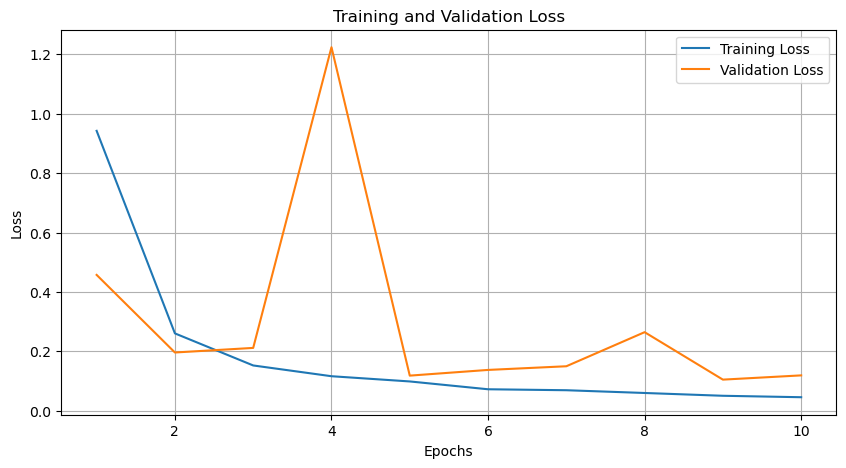

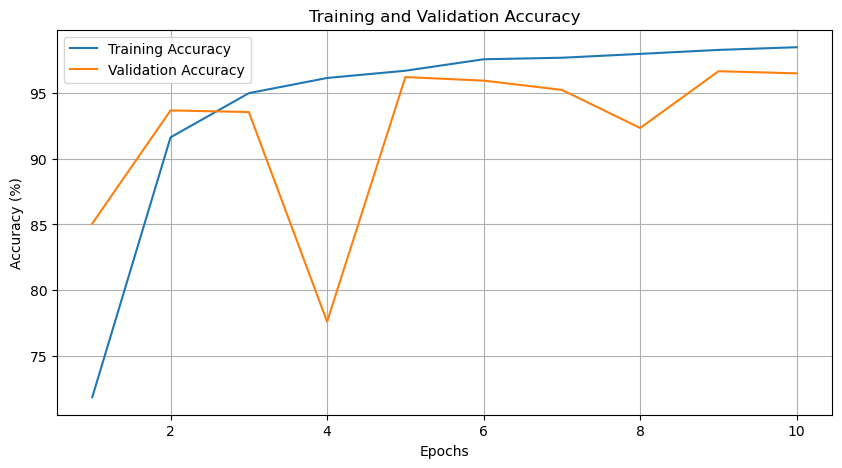

In [32]:

plot_training_history(history)

## SqueezeNet

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(squeezenet.parameters(), lr=0.001)

NameError: name 'squeezenet' is not defined

In [13]:
num_epochs = 10
history = train_model(squeezenet, train_loader, val_loader, num_epochs, criterion, optimizer, device="mps")

Epoch 1/10: 100%|██████████| 673/673 [08:41<00:00,  1.29batch/s]


Epoch [1/10], Train Loss: 3.5110, Train Accuracy: 8.79%, Val Loss: 3.4925, Val Accuracy: 8.79%


Epoch 2/10: 100%|██████████| 673/673 [12:07<00:00,  1.08s/batch]


Epoch [2/10], Train Loss: 3.5056, Train Accuracy: 8.77%, Val Loss: 3.4917, Val Accuracy: 8.79%


Epoch 3/10: 100%|██████████| 673/673 [12:59<00:00,  1.16s/batch]


Epoch [3/10], Train Loss: 3.5050, Train Accuracy: 8.67%, Val Loss: 3.4938, Val Accuracy: 8.79%


Epoch 4/10: 100%|██████████| 673/673 [12:44<00:00,  1.14s/batch]


Epoch [4/10], Train Loss: 3.5048, Train Accuracy: 8.91%, Val Loss: 3.4928, Val Accuracy: 9.12%


Epoch 5/10: 100%|██████████| 673/673 [11:42<00:00,  1.04s/batch]


Epoch [5/10], Train Loss: 3.5043, Train Accuracy: 8.78%, Val Loss: 3.4917, Val Accuracy: 9.12%


Epoch 6/10: 100%|██████████| 673/673 [12:32<00:00,  1.12s/batch]


Epoch [6/10], Train Loss: 3.5042, Train Accuracy: 8.84%, Val Loss: 3.4958, Val Accuracy: 8.79%


Epoch 7/10: 100%|██████████| 673/673 [12:12<00:00,  1.09s/batch]


Epoch [7/10], Train Loss: 3.5041, Train Accuracy: 8.78%, Val Loss: 3.4926, Val Accuracy: 9.12%


Epoch 8/10: 100%|██████████| 673/673 [11:25<00:00,  1.02s/batch]


Epoch [8/10], Train Loss: 3.5040, Train Accuracy: 8.88%, Val Loss: 3.4916, Val Accuracy: 9.12%


Epoch 9/10: 100%|██████████| 673/673 [15:35<00:00,  1.39s/batch]


Epoch [9/10], Train Loss: 3.5040, Train Accuracy: 8.83%, Val Loss: 3.4919, Val Accuracy: 9.12%


Epoch 10/10: 100%|██████████| 673/673 [38:05<00:00,  3.40s/batch]


Epoch [10/10], Train Loss: 3.5039, Train Accuracy: 8.78%, Val Loss: 3.4917, Val Accuracy: 9.12%
Training completed in: 161m 37s


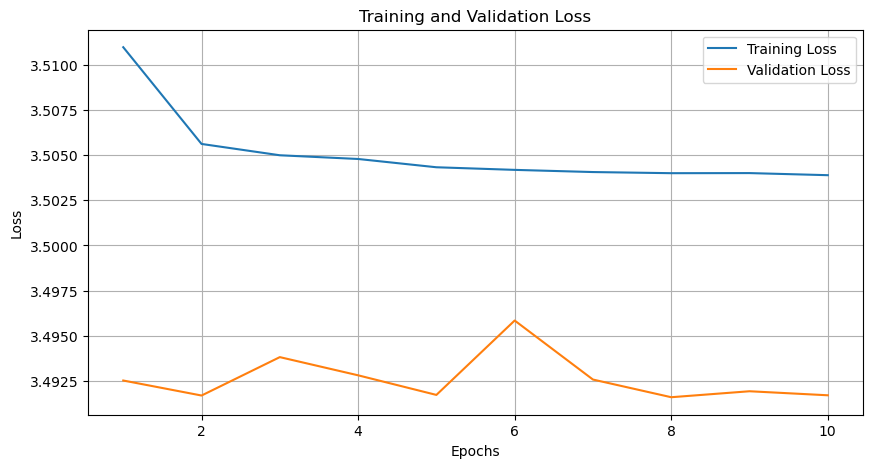

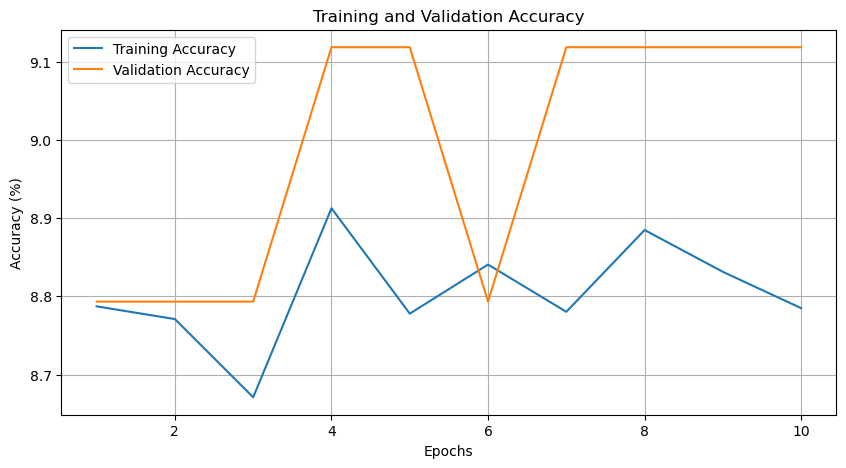

In [15]:
plot_training_history(history)

In [19]:
squeezenet.eval()

total_loss = 0.0
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = squeezenet(inputs)
    loss = criterion(outputs, labels)
    total_loss += loss.item() * inputs.size(0)

# Calculate avg loss
final_loss = total_loss / len(test_loader)
print(f"Final Loss: {final_loss:.4f}")

Final Loss: 222.4575


In [20]:
# Save a full checkpoint with additional details
checkpoint = {
    'model_state_dict': squeezenet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # Optional if you need it
    'epoch': num_epochs,
    'loss': final_loss,  # Replace final_loss with your final loss value
}
torch.save(squeezenet.state_dict(), '/Users/firmansyahsundana/Documents/tesis/checkpoints/squeezenet.pth')

# Evaluation

In [16]:
from utils import evaluate_model

# Access the classes from the underlying dataset
class_names = test_loader.dataset.dataset.classes
print("Class Names:", class_names)

Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yel

## MobileNet V1

In [23]:
# Load model

loaded_model_v0 = MobileNetV1(ch_in=3, n_classes=num_classes)
loaded_model_v0.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/mobilenetv1.pth', map_location="mps"))
loaded_model_v0

MobileNetV1(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(1, 1

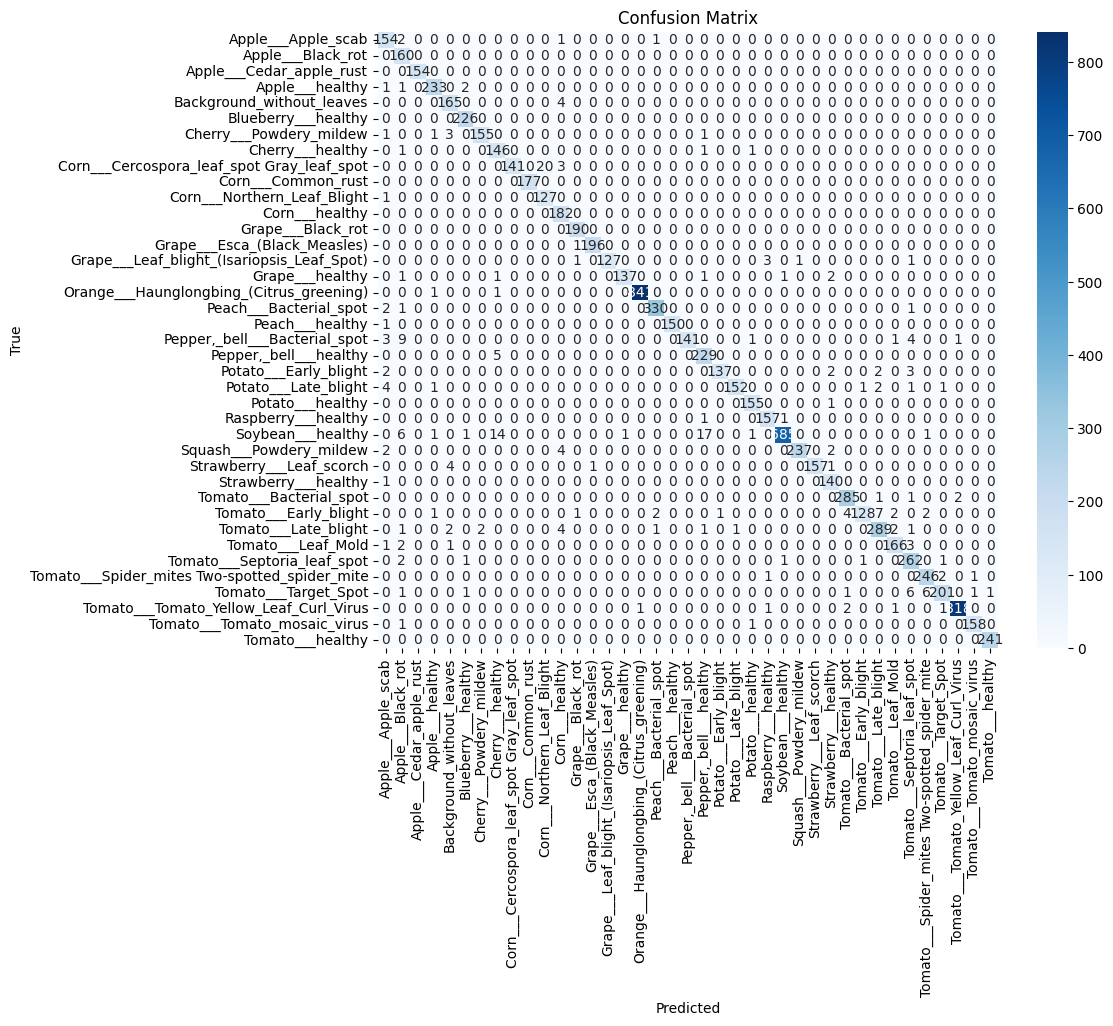

In [ ]:
cm, performance_table = evaluate_model(loaded_model_v0, test_loader, class_names)

In [ ]:
performance_table

{'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
 'Value': ['0.97', '0.97', '0.97', '0.9731']}

### Inference Time

In [34]:
from utils import calculate_inference_time

mobilenetv1_avg_time = calculate_inference_time(loaded_model_v0, test_loader)
print(f"Average Inference Time per Batch: {mobilenetv1_avg_time:.2f} ms")

Average Inference Time per Batch: 8.98 ms


## MobileNet V3

Final Loss: 5.0872


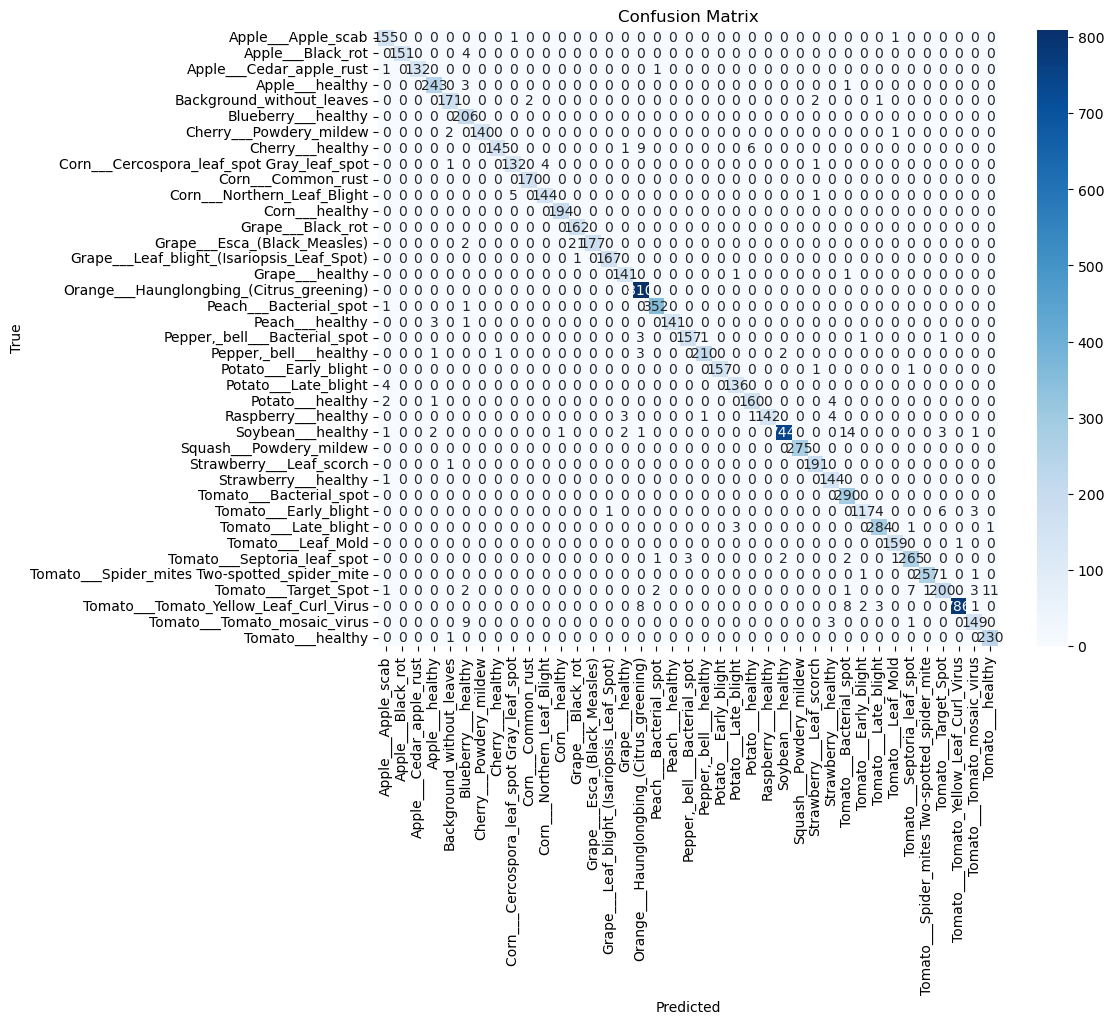

Accuracy: 0.97
Precision: 0.98
Recall: 0.97
F1 Score: 0.9742


In [78]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(mobilenetv3, criterion, test_loader, class_names, device=device)

In [82]:
performance_table

{'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
 'Value': ['0.97', '0.98', '0.97', '0.9742']}

In [84]:
# Save a full checkpoint with additional details
checkpoint = {
    'model_state_dict': mobilenetv3.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # Optional if you need it
    'epoch': num_epochs,
    'loss': final_loss,  # Replace final_loss with your final loss value
}
torch.save(mobilenetv3.state_dict(), '/Users/firmansyahsundana/Documents/tesis/checkpoints/mobilenetv3.pth')

### Inference Time

In [35]:
# Load model

loaded_mobilenet_v3 = MobileNetV3(num_classes=num_classes)
loaded_mobilenet_v3.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/mobilenetv3.pth', map_location="mps"))
loaded_mobilenet_v3

MobileNetV3(
  (first_conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (first_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_activation): Hardswish()
  (blocks): Sequential(
    (0): MobileNetV3Block(
      (activation): ReLU()
      (depthwise_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise_conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MobileNetV3Block(
      (activation): ReLU()
      (expand_conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (depthwise_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [36]:
from utils import calculate_inference_time

mobilenetv3_avg_time = calculate_inference_time(loaded_mobilenet_v3, test_loader)
print(f"Average Inference Time per Batch: {mobilenetv3_avg_time:.2f} ms")

Average Inference Time per Batch: 10.76 ms


## SqueezeNet

Final Loss: 222.4575


/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


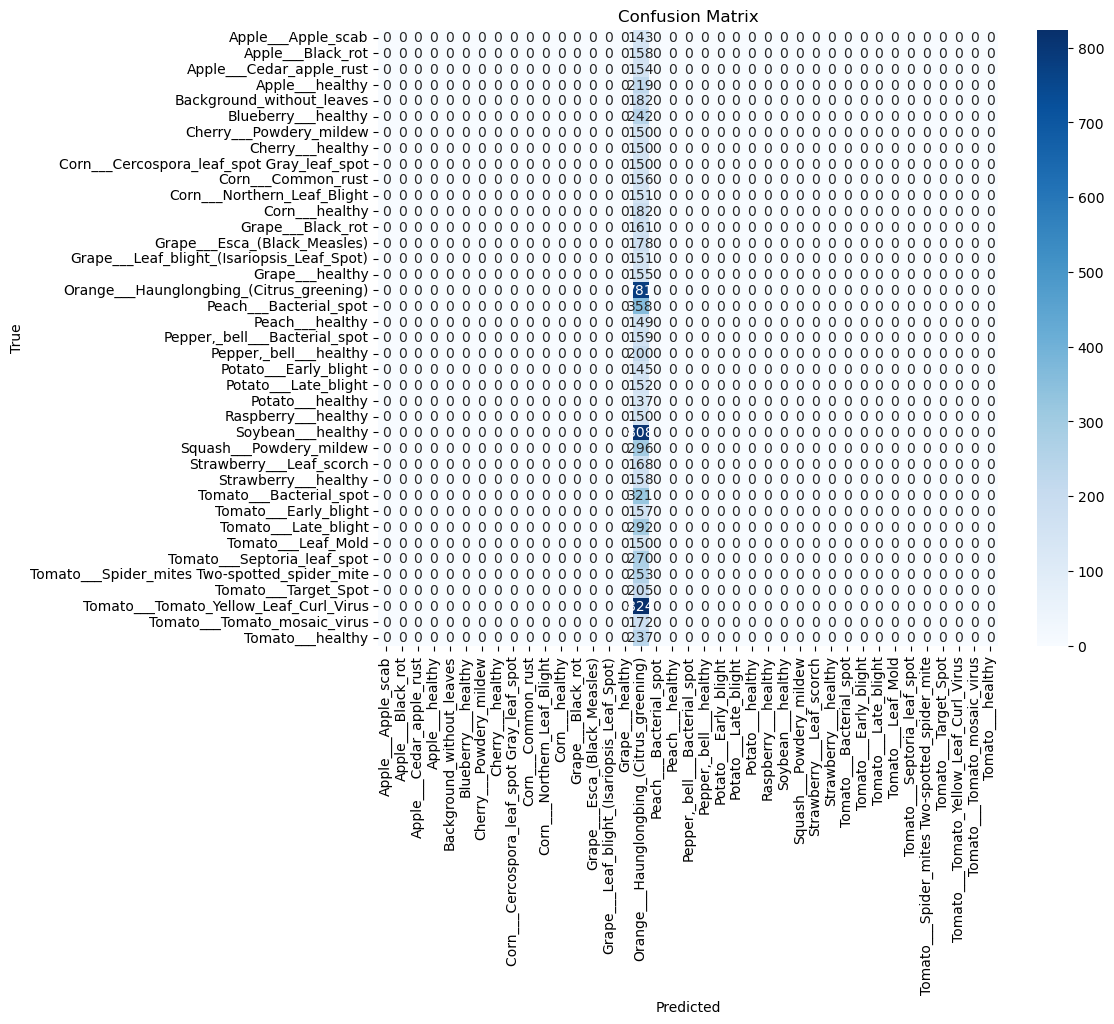

Accuracy: 0.08
Precision: 0.01
Recall: 0.08
F1 Score: 0.0132


In [21]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(squeezenet, criterion, test_loader, class_names, device=device)

In [22]:
performance_table

{'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
 'Value': ['0.08', '0.01', '0.08', '0.0132']}

### Inference Time

In [12]:
# Load model

loaded_squeezenet = SqueezeNet(num_classes=num_classes)
loaded_squeezenet.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/squeezenet.pth', map_location="mps"))
loaded_squeezenet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): FireModule(
      (squeeze): Sequential(
        (0): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
      )
      (expand_1x1): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
      )
      (expand_3x3): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (4): FireModule(
      (squeeze): Sequential(
        (0): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
      )
      (expand_1x1): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
      )
      (expand_3x3): Sequential(
        (0)

In [ ]:
from utils import calculate_inference_time

squeezenet_avg_time = calculate_inference_time(loaded_squeezenet, test_loader)
print(f"Average Inference Time per Batch: {squeezenet_avg_time:.2f} ms")

TypeError: unsupported format string passed to SqueezeNet.__format__

In [14]:
print(f"Average Inference Time per Batch: {squeezenet_avg_time:.2f} ms")

Average Inference Time per Batch: 1684.52 ms


# Results

## Model Performance

In [17]:
import pandas as pd

mobilenetv1_results = {
    "model_name": "MobileNetV1",
    "accuracy": 0.97,
    "precision": 0.97,
    "recall": 0.97,
    "f1-score": 0.9731
}

mobilenetv3_results = {
    "model_name": "MobileNetV3",
    "accuracy": 0.97,
    "precision": 0.98,
    "recall": 0.97,
    "f1-score": 0.9742
}

mobilenetv2_result = {
    "model_name": mobilenetv2.__class__.__name__,
    "accuracy": None,
    "precision": None,
    "recall": None,
    "f1-score": None
}

squeezenet_results = {
    "model_name": squeezenet.__class__.__name__,
    "accuracy": 0.08,
    "precision": 0.01,
    "recall": 0.08,
    "f1-score": 0.0132
}

In [18]:
compare_results = pd.DataFrame([mobilenetv1_results, mobilenetv3_results, squeezenet_results])
compare_results

,model_name,accuracy,precision,recall,f1-score
0,MobileNetV1,0.97,0.97,0.97,0.9731
1,MobileNetV3,0.97,0.98,0.97,0.9742
2,SqueezeNet,0.08,0.01,0.08,0.0132


## Model Complexity

In [22]:
mobilenetv1_complex = {
    "model_name": model_v0.__class__.__name__,
    "FLOPs": f"{588_000_000 / 1_000_000:.1f}M",
    "MACs": f"{294_015_000 / 1_000_000:.1f}M",
    "Params" : f"{3_250_000 / 1000:.1f}K",
    "training (minutes)": 200,
    "inference (ms)": 8.98
}

mobilenetv2_complex = {
    "model_name": mobilenetv2.__class__.__name__,
    "FLOPs": f"{317_850_000 / 1_000_000:.1f}M",
    "MACs": f"{158_925_000 / 1000000:.1f}M",
    "Params" : f"{2_240_000 / 1000:.1f}K",
    "training (minutes)": None,
    "inference (ms)": None
}

mobilenetv3_complex = {
    "model_name": mobilenetv3.__class__.__name__,
    "FLOPs": f"{3_210_000 / 1_000_000:.1f}M",
    "MACs": f"{1_605_000 / 1000000:.1f}M",
    "Params": f"{942_260 / 1000:.1f}K",
    "training (minutes)": 123,
    "inference (ms)": 10.76
}

squeezenet_complex = {
    "model_name": squeezenet.__class__.__name__,
    "FLOPs": f"{16_520_000 / 1_000_000:.1f}M",
    "MACs": f"{16_520_000 / 2 / 1000000:.1f}M",
    "Params": f"{755_430 / 1000:.1f}K",
    "training (minutes)": 161,
    "inference (ms)": 1684.52
}

In [23]:
compare_complex = pd.DataFrame([mobilenetv1_complex, mobilenetv2_complex, mobilenetv3_complex, squeezenet_complex])
compare_complex

,model_name,FLOPs,MACs,Params,training (minutes),inference (ms)
0,MobileNetV1,588.0M,294.0M,3250.0K,200.0,8.98
1,MobileNetV2,317.9M,158.9M,2240.0K,NaN,NaN
2,MobileNetV3,3.2M,1.6M,942.3K,123.0,10.76
3,SqueezeNet,16.5M,8.3M,755.4K,161.0,1684.52
